# *Entregable 2 Deep Learning: Redes Convolucionales*
- Rubén Gil Martínez

# **P2.1**

**E1:** Carga las imágenes de entrada y sus identificadores de clase correspondientes. Almacénalos en dos tensores con las dimensiones adecuadas para servir de entrada y salida (entrenamiento) respectivamente de la red neuronal construida.

**E2:** Aleatoriza la posición de las imágenes y consecuentemente los identificadores.

**E3:** Particiona los tensores de entrada en dos, asigna el 80% de las imágenes para el entrenamiento y el 20% para la validación.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential, optimizers
import os
from keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Ruta del conjunto de datos
data_path = '../data/imgs/SNR_high'

# Dimensiones de las imágenes
img_size = (50, 50)

# Cargar imágenes y etiquetas
images = []
labels = []

for filename in os.listdir(data_path):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        # Extraer la etiqueta del nombre del archivo
        label = str(filename.split('_')[0])  
        
        # Cargar imagen en escala de grises
        img_path = os.path.join(data_path, filename)
        image = load_img(img_path, color_mode='grayscale', target_size=img_size)
        image = img_to_array(image) / 255.0  # Normalizar los valores de los píxeles
        
        images.append(image)
        labels.append(label)


# Codificar las etiquetas para que sean números enteros, importante ya que la red neuronal solo acepta números
labels = LabelEncoder().fit_transform(labels) 

# Convertir listas a arreglos numpy
images = np.array(images , dtype= np.float32)  
labels = np.array(labels, dtype= np.int32)

# Aleatorizamos la posición de las imágenes y etiquetas con la herramienta shuffle de sklearn para evitar sesgos
images , labels = shuffle(images, labels, random_state=2025)

# Partición en entrenamiento (80%) y validación (20%)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=2025)

# Imprimir dimensiones resultantes
print("Tamaño del conjunto de entrenamiento: Datos:", X_train.shape, "Etiquetas:", y_train.shape)
print("Tamaño del conjunto de validación: Datos:", X_val.shape, "Etiquetas:", y_val.shape)


Tamaño del conjunto de entrenamiento: Datos: (400, 50, 50, 1) Etiquetas: (400,)
Tamaño del conjunto de validación: Datos: (100, 50, 50, 1) (100,)


**E4:** Construye un MLP que realice la clasificación de las imágenes según se especifica en el apartado [MLP baseline](mlp). Utiliza el algoritmo de optimización y la función de pérdidas que creas más oportuna.

**Utilizamos Adam como algoritmo de optimizción adaptativo, varía el tamaño del learning en función de lo cerca/lejos que nos encontremos del mínimo global y como función de pérdidas se emplea sparse_categorical_crossentropy ya que estamos ante un problema de clasificación multiclase.**

**E5:** ¿Cuántos parámetros a entrenar tendría esta red?
**Contiene 1,453,317 de parámetros entrenables debido a las múltiples conexiones entre todas las neuronas.**

**E6:** Entrena el modelo y encuentra la combinación de tamaño de batch y épocas que genere mejores resultados.

**Tras varios entrenamientos, encontramos la combinación de 200 épocas y tamaño de batch 64 como la mejor opción en cuanto a resultados.**

In [17]:
# Definimos un earling stop para detener el entrenamiento de los modelos cuando ya no mejoren la precisión de la validación
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',  # Métrica a monitorear 
    patience=40,  # Número de epochs sin mejora antes de parar
    min_delta=0.001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [6]:
model = Sequential([ 
    layers.Input(shape=(2500,)),
    layers.Dense(512, activation='leaky_relu'),
    layers.Dense(256, activation='leaky_relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     1,280,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,453,317 (5.54 MB)

 Trainable params: 1,453,317 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Aplanamos las imágenes para que puedan ser procesadas por la red
X_train_MLP = X_train.reshape(X_train.shape[0], 2500, 1)
X_val_MLP = X_val.reshape(X_val.shape[0], 2500, 1)

In [8]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train_MLP, y_train, epochs=150, batch_size=32, validation_data=(X_val_MLP, y_val), callbacks=[early_stopping])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.1437 - loss: 2.5047 - val_accuracy: 0.2200 - val_loss: 2.1576
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2161 - loss: 1.9565 - val_accuracy: 0.3000 - val_loss: 1.7439
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2627 - loss: 1.7199 - val_accuracy: 0.2600 - val_loss: 1.7695
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2541 - loss: 1.8090 - val_accuracy: 0.2000 - val_loss: 1.7283
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2285 - loss: 1.6439 - val_accuracy: 0.2500 - val_loss: 1.5244
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3949 - loss: 1.4591 - val_accuracy: 0.2100 - val_loss: 1.5611
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.4236 - loss: 1.3846 - val_accuracy: 0.4200 - val_loss: 1.4411
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3845 - loss: 1.3485 - val_accuracy: 0.48

**E7:** Muestra la evolución de la función de pérdidas para los conjuntos de datos de entrenamiento y validación a lo largo del proceso de entrenamiento.

**E8:** ¿Qué precisión tiene el modelo?

In [10]:
# Suponiendo que usaste EarlyStopping como callback
best_epoch = early_stopping.best_epoch
print(f"La mejor época según EarlyStopping fue la {best_epoch}")


La mejor época según EarlyStopping fue la 105


Text(0.5, 1.0, 'Evolución de la función de pérdida a lo largo del entrenamiento')

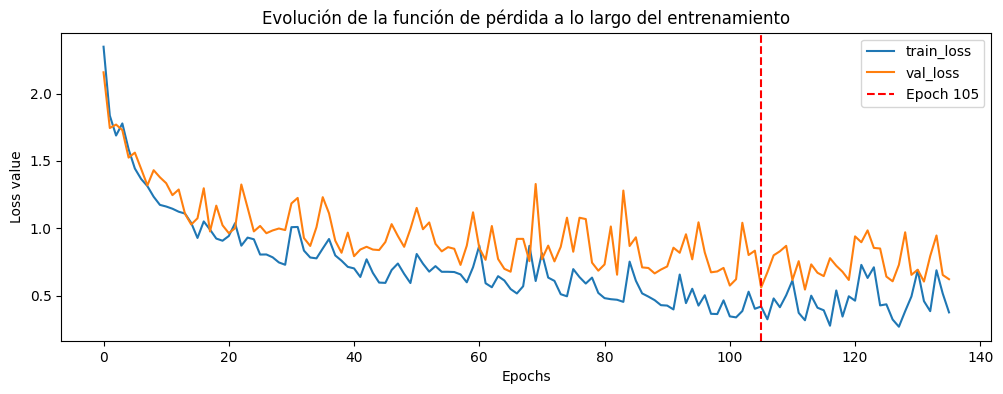

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
# Línea vertical en la época 22
plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Epoch {best_epoch}')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.title('Evolución de la función de pérdida a lo largo del entrenamiento')

In [12]:
# Evaluar el modelo en el conjunto de validación
_, accuracy = model.evaluate(X_val_MLP, y_val)
print(f"Precisión en datos de validación: {accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8424 - loss: 0.5177 
Precisión en datos de validación: 0.83


In [13]:
# Podemos observar este mismo dato en el historial de entrenamiento, último valor de la exactitud en el conjunto de validación.
print(f"Exactitud del modelo con datos de entrenamiento: ", history.history['accuracy'][best_epoch], f" \n Exactitud del modelo con datos de validación: ", history.history['val_accuracy'][best_epoch])

Exactitud del modelo con datos de entrenamiento:  0.8525000214576721  
 Exactitud del modelo con datos de validación:  0.8299999833106995


**E9:** Construye una red neuronal para clasificar las imágenes del dataset que contenga capas convolucionales y un MLP. Utiliza el algoritmo de optimización y la función de pérdidas que creas más oportuna.

**E10:** ¿Cuántos parámetros a entrenar tendría esta red? Compáralos con los que se obtuvieron con el MLP.
**Esta red, por la arquitectura que he decidido tomar, 3 capas convolucionales, 2 capas de MaxPooling y una red final Fully Conected(FC) con una capa oculta, contiene 716,485 parámetros entrenables, bastantes menos que los utilizados en la arquitectura MLP. Esto se da porque, en esta arquitectura, los pesos son los coeficientes de los filtros y esos pesos son aplicados a todos los datos(píxeles) de la imagen de entrada. Sin embargo, en MLP se utilizan pesos específicos para tratar cada dato/píxel de entrada, de ahí viene la disminución de la cantidad de parámetros a entrenar.**

**E11:** Entrena el modelo y determina la precisión de la clasificación. Discute los resultados en comparación con los que se obtuvieron con el MLP

**Pues podemos observar que con una red convolucional se consiguen mejores resultados cuando tratamos con imágenes, es una arquitectura que esta diseñada específicamente para tratar con estas y poder aprender todas sus características, por otro lado, el MLP es mucho más general ya que NO consigue mantener la importante información espacial que llevan intrínseca las imágenes.**

In [14]:
CNN_model = Sequential([
    layers.Input(shape=(50, 50, 1)),  # Escala de grises

    layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (5, 5), strides=(2, 2), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')  # Capa de salida
])

CNN_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 50, 50, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 716,933 (2.73 MB)

 Trainable params: 716,485 (2.73 MB)

 Non-trainable params: 448 (1.75 KB)

In [18]:
CNN_model.compile((optimizers.Adagrad(learning_rate=0.01)), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

CNN_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7228 - loss: 0.6407 - val_accuracy: 0.3800 - val_loss: 1.5677
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7922 - loss: 0.5013 - val_accuracy: 0.2200 - val_loss: 1.5797
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8516 - loss: 0.4083 - val_accuracy: 0.2200 - val_loss: 1.5613
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9044 - loss: 0.3206 - val_accuracy: 0.2200 - val_loss: 1.5711
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9065 - loss: 0.2561 - val_accuracy: 0.2200 - val_loss: 1.5917
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8865 - loss: 0.3014 - val_accuracy: 0.2200 - val_loss: 1.6041
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9116 - loss: 0.2205 - val_accuracy: 0.2200 - val_loss: 1.6078
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8463 - loss: 0.3309 - val_accuracy: 0.

In [19]:
_, accuracy = CNN_model.evaluate(X_val, y_val)
print(f"Precisión en datos de validación: {accuracy:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9234 - loss: 0.4533 
Precisión en datos de validación: 0.91


**E12:** Muestra la matriz de confusión resultado de procesar el conjunto de datos de test.

**E13:** ¿Qué dos clases presentan mayor confusión mutua? ¿Por qué? Visualiza unas cuantas imágenes con clasificaciones correctas e incorrectas.
**Las clases que presentan mayor confusión mutua son 6utj con 3j9i y 4cr2 con 4v94  debido a que tiene una estructura, intensidad y forma parecidas.**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


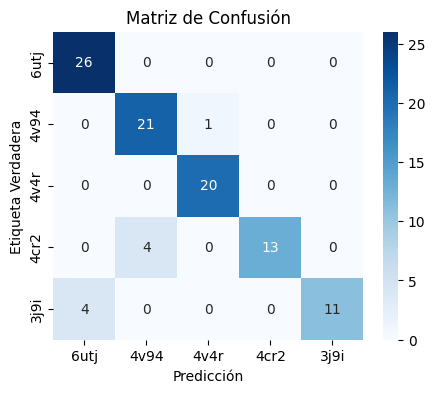

              precision    recall  f1-score   support

        6utj       0.87      1.00      0.93        26
        4v94       0.84      0.95      0.89        22
        4v4r       0.95      1.00      0.98        20
        4cr2       1.00      0.76      0.87        17
        3j9i       1.00      0.73      0.85        15

    accuracy                           0.91       100
   macro avg       0.93      0.89      0.90       100
weighted avg       0.92      0.91      0.91       100



In [ ]:
class_names = ['6utj', '4v94', '4v4r', '4cr2', '3j9i']
# Predicciones
y_pred = np.argmax(CNN_model.predict(X_val), axis=-1)

# Matriz de confusión
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

# Reporte de métricas
print(classification_report(y_val, y_pred, target_names=class_names))


**Visualización de imágenes de ejemplo: Podemos observar como hay cierto parecido en las intensidades de las escalas de grises y la forma de las proteinas lo que puede llevar a la confusión a nuestra red a la hora de clasificar una y otra clase.**

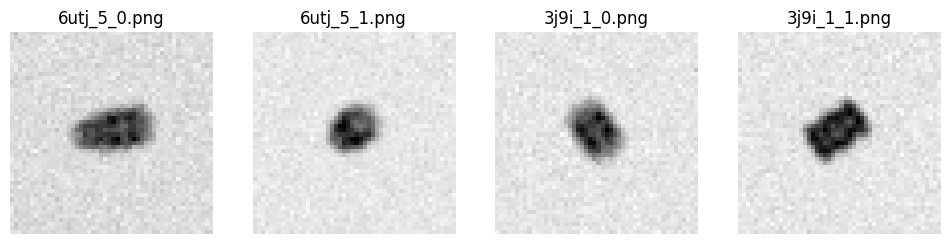

In [21]:
seis_utj_1 = load_img('../data/imgs/SNR_high/6utj_5_0.png', color_mode='grayscale', target_size=img_size)
seis_utj_2 = load_img('../data/imgs/SNR_high/6utj_5_1.png', color_mode='grayscale', target_size=img_size)
tres_j9i_1 = load_img('../data/imgs/SNR_high/3j9i_1_0.png', color_mode='grayscale', target_size=img_size)
tres_j9i_2 = load_img('../data/imgs/SNR_high/3j9i_1_1.png', color_mode='grayscale', target_size=img_size)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(seis_utj_1, cmap='gray')
plt.axis('off')
plt.title('6utj_5_0.png')
plt.subplot(1, 4, 2)
plt.imshow(seis_utj_2, cmap='gray')
plt.axis('off')
plt.title('6utj_5_1.png')
plt.subplot(1, 4, 3)
plt.imshow(tres_j9i_1, cmap='gray')
plt.axis('off')
plt.title('3j9i_1_0.png')
plt.subplot(1, 4, 4)
plt.imshow(tres_j9i_2, cmap='gray')
plt.axis('off')
plt.title('3j9i_1_1.png')
plt.show()


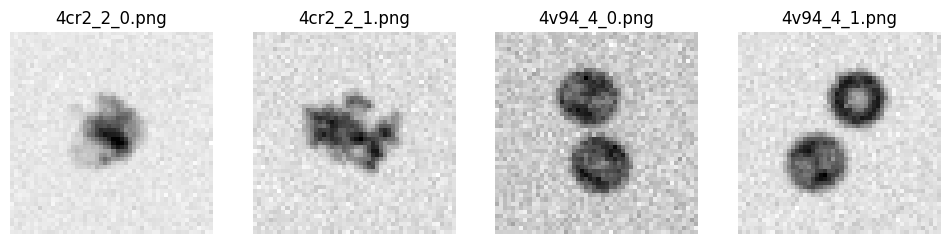

In [22]:
seis_utj_1 = load_img('../data/imgs/SNR_high/4cr2_2_0.png', color_mode='grayscale', target_size=img_size)
seis_utj_2 = load_img('../data/imgs/SNR_high/4cr2_2_1.png', color_mode='grayscale', target_size=img_size)
tres_j9i_1 = load_img('../data/imgs/SNR_high/4v94_4_0.png', color_mode='grayscale', target_size=img_size)
tres_j9i_2 = load_img('../data/imgs/SNR_high/4v94_4_1.png', color_mode='grayscale', target_size=img_size)

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.imshow(seis_utj_1, cmap='gray')
plt.axis('off')
plt.title('4cr2_2_0.png')
plt.subplot(1, 4, 2)
plt.imshow(seis_utj_2, cmap='gray')
plt.axis('off')
plt.title('4cr2_2_1.png')
plt.subplot(1, 4, 3)
plt.imshow(tres_j9i_1, cmap='gray')
plt.axis('off')
plt.title('4v94_4_0.png')
plt.subplot(1, 4, 4)
plt.imshow(tres_j9i_2, cmap='gray')
plt.axis('off')
plt.title('4v94_4_1.png')
plt.show()


# **P2.2**

**E1:** Carga las imágenes de entrada del directorio y preprocésalas según se especifica en la sección [El dataset](#dataset). Almacénalas en tensores con las dimensiones adecuadas para servir de entrada y/o salida una red U-Net.

**E2:** Aleatoriza la posicion de las imágenes y consecuentemente los identificadores.

**E3:** Particiona los tensores de entrada en dos, asigna el 80% de las imágenes para el entrenamiento y el 20% para la validación.

In [2]:
import mrcfile

def load_mrc(fname, mmap=False, no_saxes=True):
    """
    Load an input MRC tomogram as ndarray
    :param fname: the input MRC
    :param mmap: if True (default False) the data are read as a memory map
    :param no_saxes: if True (default) then X and Y axes are swapped to cancel the swapping made by mrcfile package
    :return: a ndarray (or memmap if mmap=True)
    """
    if mmap:
        mrc = mrcfile.mmap(fname, permissive=True, mode='r+')
    else:
        mrc = mrcfile.open(fname, permissive=True, mode='r+')
    if no_saxes:
        return np.swapaxes(mrc.data, 0, 2)
    return mrc.data


def center_crop(image, size=56):
    """
    Crop the center of the image to the desired size.
    """
    h, w, _ = image.shape
    start_h = (h - size) // 2
    start_w = (w - size) // 2
    return image[start_h:start_h + size, start_w:start_w + size]


def load_dataset(noisy_path, clean_path, size=56):
    """
    Load MRC images from directories and preprocess them.
    :param noisy_path: Path to noisy images
    :param clean_path: Path to clean images
    :param size: Target crop size
    :return: Tuple of numpy arrays (noisy_images, clean_images)
    """
    print("Loading dataset...")
    noisy_images, clean_images = [], []
    
    noisy_files = sorted(os.listdir(noisy_path))
    clean_files = sorted(os.listdir(clean_path))
    
    for noisy_file, clean_file in zip(noisy_files, clean_files):
        if noisy_file.endswith('.mrc') and clean_file.endswith('.mrc'):
            noisy_img = load_mrc(os.path.join(noisy_path, noisy_file))
            clean_img = load_mrc(os.path.join(clean_path, clean_file))
            
            noisy_img = center_crop(noisy_img, size)
            clean_img = center_crop(clean_img, size)
            
            noisy_images.append(noisy_img.astype(np.float32))
            clean_images.append(clean_img.astype(np.float32))
    print("Dataset loaded.")
    
    return np.array(noisy_images), np.array(clean_images)

In [3]:
# Cargar el conjunto de datos
noisy_dir = "../data/SNR_low/noisy"
clean_dir = "../data/SNR_low/clean"
noisy_dataset, clean_dataset = load_dataset(noisy_dir, clean_dir)

Loading dataset...
Dataset loaded.


In [4]:
# Normalizamos los valores de los píxeles entre -1 y 1
X = noisy_dataset / noisy_dataset.max()
Y = clean_dataset / clean_dataset.max()

# Aleatorizamos la posición de las imágenes mediante la función shuffle de sklearn
X, Y = shuffle(X, Y, random_state=2025)

# Partición en entrenamiento (80%) y validación (20%)
x_t, x_v, y_t, y_v = train_test_split(X, Y, test_size=0.2, random_state=2025)

# Imprimir dimensiones resultantes
print("Tamaño del conjunto de entrenamiento: Ruidosas:", x_t.shape, "Objetivo:", y_t.shape)
print("Tamaño del conjunto de validación: Ruidosas:", x_v.shape, "Objetivo:", y_v.shape)

Tamaño del conjunto de entrenamiento: Ruidosas: (400, 56, 56, 1) Objetivo: (400, 56, 56, 1)
Tamaño del conjunto de validación: Ruidosas: (100, 56, 56, 1) Objetivo: (100, 56, 56, 1)


**E4:** Adapta la arquitectura mostrada en la sección [Restauración de imágenes](#restauracion) red para resolver la tarea de restauración de las imágenes cargadas en el ejercicio anterior.

**E5:** Entrénala teniendo en cuenta la función de perdidas que mejor se ajusta al problema de restauración propuesto. Fija unos parámetros que te permitan conseguir sobreajuste.

**Utilizamos como métricas mae y mse ya que el objetivo será que el valor de los píxeles de la imagen generada sea lo más cercano posible al valor real del correspondiente píxel en la imagen real/limpia, por otro lado, fijaremos 50 épocas de entrenamiento con lotes de tamaño 64 para conducir a la red al sobreajuste.**

**Observaremos qué tal se comporta mostrando algunas imágenes de las restauraciones realizadas por ella.**

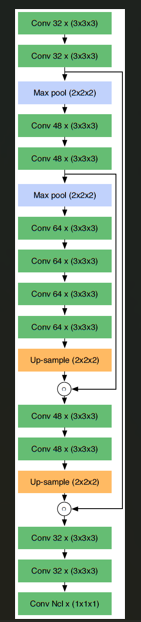 **Arquitectura desarrollada por DeepFinder que trataremos de adaptar para la restauración de nuestras imágenes de microscopía.**


In [ ]:
# Creación arquitecura U-Net para restauración de imagen
def architecture_u_net_2d(input_shape=(56, 56, 1)):
    inputs = layers.Input(shape=input_shape)

    # Down-sampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Up-sampling
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c2])  # Skip connection
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Concatenate()([u2, c1])  # Skip connection
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Salida
    outputs = layers.Conv2D(1, (1, 1), activation='tanh', padding='same')(u2) # Utilizamos la función de activación tangente hiperbólica para que los valores estén entre -1 y 1

    return keras.Model(inputs, outputs)

# Crear modelo
u_net_model = architecture_u_net_2d()

# Resumen del modelo
u_net_model.summary()


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 56, 56, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 56, 56,    │        320 │ input_layer_15[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 56, 56,    │      9,248 │ conv2d_195[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_30    │ (None, 28, 28,    │          0 │ conv2d_196[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 28, 28,    │     13,872 │ max_pooling2d_30… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_197[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_31    │ (None, 14, 14,    │          0 │ conv2d_198[0][0]  │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_199 (Conv2D) │ (None, 14, 14,    │     27,712 │ max_pooling2d_31… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_200 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_199[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_201 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_200[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_202 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_201[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_30    │ (None, 28, 28,    │          0 │ conv2d_202[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_30      │ (None, 28, 28,    │          0 │ up_sampling2d_30… │
│ (Concatenate)       │ 112)              │            │ conv2d_198[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 28, 28,    │     48,432 │ concatenate_30[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_203[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_31    │ (None, 56, 56,    │          0 │ conv2d_204[0][0]  │
│ (UpSampling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 56, 56,    │          0 │ up_sampling2d_31

 Total params: 284,289 (1.08 MB)

 Trainable params: 284,289 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

**Para inducir al sobreajuste de la red haremos lo siguiente:**
1) No aplicaremos técnicas de regularización 
2) Tasa de aprendizaje alta
3) Muchas épocas 

In [87]:
# Compilamos el modelo: Utilizamos como métricas mae y mse ya que el objetivo será que el valor de los píxeles de la imagen generada sea lo 
# más cercano posible al valor real del correspondiente píxel en la imagen real.
u_net_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse', metrics=['mae'])


# Entrenamos el modelo: Utilizamos 150 épocas y un tamaño de lote de 16 para abocar al modelo al sobreajuste.
history = u_net_model.fit(x_t, y_t, epochs=150, batch_size=16, validation_data=(x_v, y_v))

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0116 - mae: 0.0486 - val_loss: 0.0105 - val_mae: 0.0533
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0107 - mae: 0.0556 - val_loss: 0.0188 - val_mae: 0.0746
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0113 - mae: 0.0602 - val_loss: 0.0084 - val_mae: 0.0458
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0075 - mae: 0.0402 - val_loss: 0.0045 - val_mae: 0.0234
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0076 - mae: 0.0354 - val_loss: 0.0069 - val_mae: 0.0306
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0062 - mae: 0.0319 - val_loss: 0.0036 - val_mae: 0.0184
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0039 - mae: 0.0219 - val_loss: 0.0044 - val_mae: 0.0209
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0038 - mae: 0.0204 - val_loss: 0.0032 - val_mae: 0.0218
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - lo

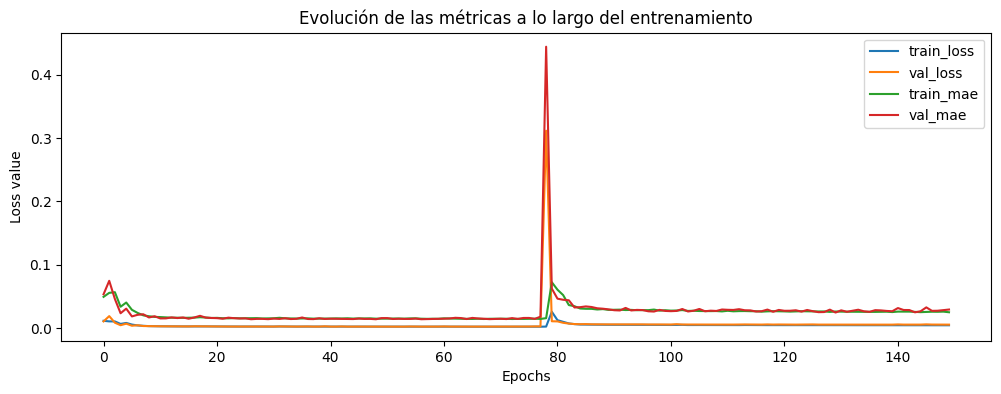

In [90]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.legend()
plt.title('Evolución de las métricas a lo largo del entrenamiento')
plt.show()

**E6:** Visualiza algunos ejemplos de imágenes restauradas comparadas con las imágenes de partida y las imágenes sin distorsiones. ¿Se consigue eliminar el ruido? ¿Se consigue restaurar perfectamente la estructura de la molécula original?

**Aparentemente se consigue eliminar el ruido intenso que contienen las imágenes de entrada pero aparece cierto ruido en la salida debido a que la red identifica patrones donde realmente no hay nada. Se consigue restaurar una parte importante de la estructura de las moléculas pero, observando la gráfica de arriba, podemos ver que el modelo está sobreentrenado(claramente se ve en las oscilaciones y cambio de escalón de val_mae y val_loss).**

In [88]:
images_to_restore = x_v[:4]
restored_images = u_net_model.predict(images_to_restore)
real_images = y_v[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


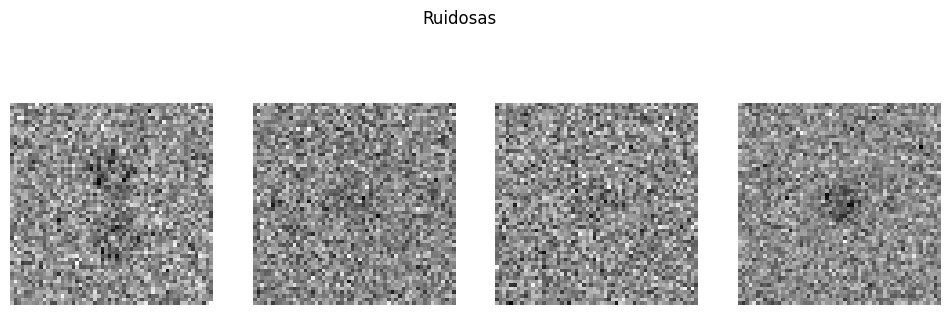

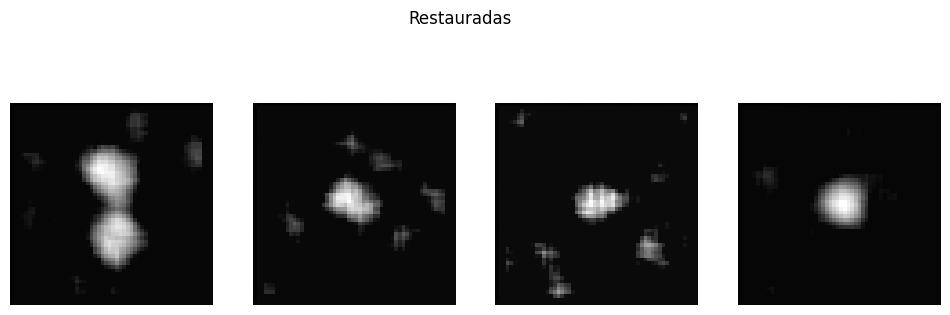

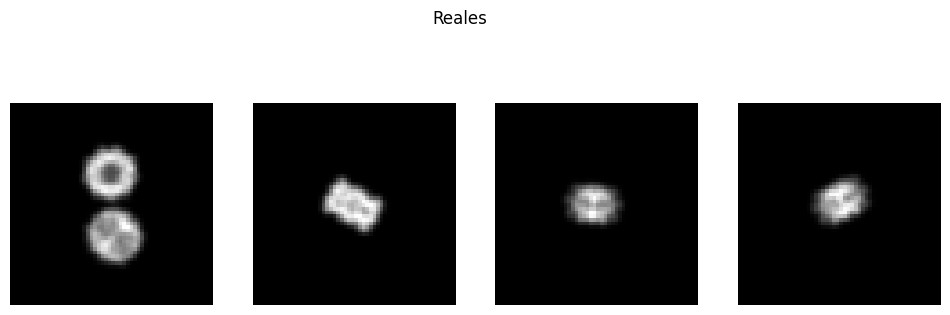

In [ ]:
plt.figure(figsize=(12, 4))
plt.suptitle('Ruidosas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_restore[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Restauradas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(restored_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Reales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(real_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')



## **Pasemos ahora a realizar el entrenamiento de esta correctamente para no caer en el sobreajuste y conseguir así un buen resultado de restauración de las imágenes:**



**E7:** Repite los ejercicios E5 e E6 pero añadiendo unos mecanismos de parada temprana para evitar la aparición de sobre ajuste. ¿Cuánto dura ahora el entrenamiento? ¿Se ha conseguido un mejor resultado? ¿Por qué?

**Ahora el entrenamiento dura bastante menos ya que es finalizado cuando se observa que la función de pérdidas de validación no decrece o crece, esto se consigue gracias al Early Stopping definido.**
**Por supuesto que se consigue un mejor resultado, porque ahora si estamos tratando de evitar el sobreajuste del modelo consiguiendo así una buena generalización en su comportamiento ante nuevas imágenes.**

In [98]:
# Crear modelo
u_net_model_best = architecture_u_net_2d()

# Resumen del modelo
u_net_model_best.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 56, 56, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_208 (Conv2D) │ (None, 56, 56,    │        320 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_209 (Conv2D) │ (None, 56, 56,    │      9,248 │ conv2d_208[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 28, 28,    │          0 │ conv2d_209[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 28, 28,    │     13,872 │ max_pooling2d_32… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_211 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_210[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 14, 14,    │          0 │ conv2d_211[0][0]  │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 14, 14,    │     27,712 │ max_pooling2d_33… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_213 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_212[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_213[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_215 (Conv2D) │ (None, 14, 14,    │     36,928 │ conv2d_214[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_32    │ (None, 28, 28,    │          0 │ conv2d_215[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 28, 28,    │          0 │ up_sampling2d_32… │
│ (Concatenate)       │ 112)              │            │ conv2d_211[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_216 (Conv2D) │ (None, 28, 28,    │     48,432 │ concatenate_32[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_217 (Conv2D) │ (None, 28, 28,    │     20,784 │ conv2d_216[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_33    │ (None, 56, 56,    │          0 │ conv2d_217[0][0]  │
│ (UpSampling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_33      │ (None, 56, 56,    │          0 │ up_sampling2d_33

 Total params: 284,289 (1.08 MB)

 Trainable params: 284,289 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

**Early Stopping**

In [99]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_mae',  # Métrica a monitorear 
    patience=50,  # Número de epochs sin mejora antes de parar
    min_delta=0.00001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [100]:
# Compilamos el modelo con un learning rate de inicial correcto para conseguir un aprendizaje progresivo
u_net_model_best.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])


# Entrenamos el modelo: Utilizamos 150 épocas, un tamaño de lote de 16 y definimos un Early Stopping para parar el entrenamiento en caso de indicio de sobreajuste.
history = u_net_model_best.fit(x_t, y_t, epochs=150, batch_size=16, validation_data=(x_v, y_v), callbacks=[early_stopping])

Epoch 1/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0107 - mae: 0.0476 - val_loss: 0.0100 - val_mae: 0.0664
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0090 - mae: 0.0478 - val_loss: 0.0055 - val_mae: 0.0369
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0040 - mae: 0.0230 - val_loss: 0.0033 - val_mae: 0.0210
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0028 - mae: 0.0184 - val_loss: 0.0026 - val_mae: 0.0170
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0024 - mae: 0.0157 - val_loss: 0.0024 - val_mae: 0.0168
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0022 - mae: 0.0155 - val_loss: 0.0023 - val_mae: 0.0159
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0024 - mae: 0.0156 - val_loss: 0.0023 - val_mae: 0.0154
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0024 - mae: 0.0154 - val_loss: 0.0028 - val_mae: 0.0168
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - lo

In [101]:
images_to_restore = x_v[:4]
restored_images = u_net_model_best.predict(images_to_restore)
real_images = y_v[:4]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step


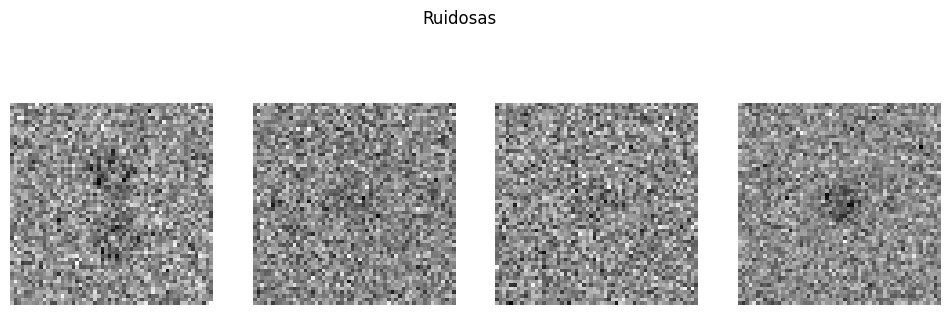

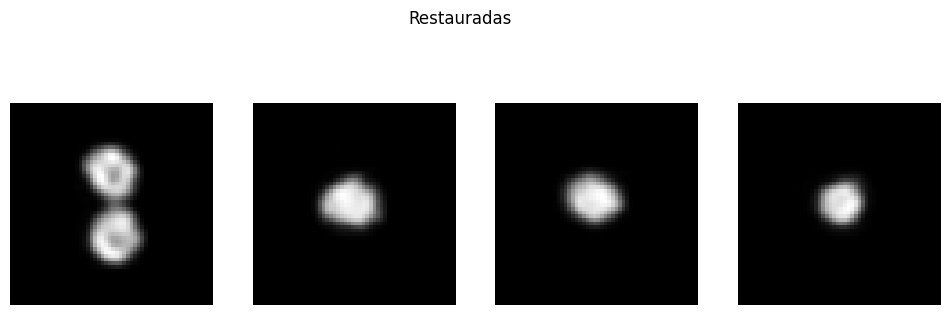

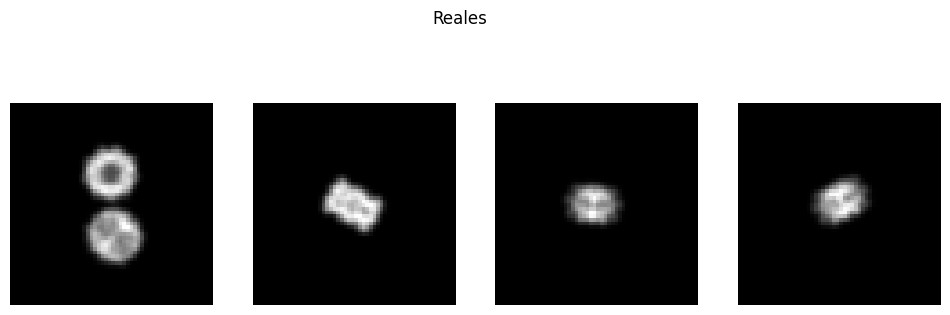

In [102]:
plt.figure(figsize=(12, 4))
plt.suptitle('Ruidosas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_restore[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Restauradas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(restored_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

plt.figure(figsize=(12, 4))
plt.suptitle('Reales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(real_images[i].reshape(56, 56), cmap='gray')
    plt.axis('off')

# **P2.3**

**E1:** Adapta la red empleada anteriormente para restauración de imágenes para resolver el problema de la segmentación semántica.

**E2:** Carga los tomogramas del dataset y genera un conjunto de imágenes 2D resultados cortar el tomograma en el plano X-Y (las dos primeras dimensiones) para todas la coordenadas del eje Z (la última dimensión).


In [96]:
def get_xy_slices_tomograms(tomo, tomo_ground_truth):
    train_all_slices = []
    test_all_slices = []
    
    for slice in range(100):
        # Corte en el plano X-Y
        train_all_slices.append(tomo[:, :, slice])
        test_all_slices.append(tomo_ground_truth[:, :, slice])
    
    return np.array(train_all_slices), np.array(test_all_slices, dtype= np.uint8)

In [97]:
# Dataset
tomo = load_mrc('../data/tomo/tomo.mrc')
tomo_ground_truth = load_mrc('../data/tomo/tomo_gt.mrc')
print("Dimensiones del tomograma:", tomo.shape, tomo_ground_truth.shape)

# Corte en el plano X-Y:
train_slices_xy, test_slices_xy = get_xy_slices_tomograms(tomo, tomo_ground_truth)

Dimensiones del tomograma: (400, 400, 100) (400, 400, 100)


**Antes de pasar a la arquitectura y al entrenamiento del modelo haremos un undersampling mediante resize a las imágenes, tanto de entrada como las ya segmentadas, para conseguir una mayor eficiencia en el entrenamiento, tener en cuenta que no utilizaremos interpolación ya que puede incurrir en que ciertas partes de las imágenes tengan valores incorrectos, especialmente en las imágenes ground truth.**

**Por otro lado, normalizaremos las imágenes de entrada entre [-1, 1] para facilitar la tarea al modelo y convertiremos las imágenes ground truth en tensores mediante one-hot encoding para poder realizar el entrenamiento y el cálculo de la función de pérdidas correctamente.**

In [150]:
# Función para redimensionar imágenes con undersampling
import cv2
def resize_images(train_slices, test_slices, target_size=(200, 200)):
    train_slices_resized = []
    test_slices_resized = []
    for image in range(len(train_slices)):
        train_slices_resized.append(cv2.resize(train_slices[image], target_size, interpolation=cv2.INTER_NEAREST))
        test_slices_resized.append(cv2.resize(test_slices[image], target_size, interpolation=cv2.INTER_NEAREST))
    return np.array(train_slices_resized), np.array(test_slices_resized)


train_xy, test_xy = resize_images(train_slices_xy, test_slices_xy)
print("Imágenes redimensionadas mediante undersampling: ", train_xy.shape, test_xy.shape)

Imágenes redimensionadas mediante undersampling:  (100, 200, 200) (100, 200, 200)


In [99]:
def normalize_images(images):
    images = np.array(images, dtype=np.float32)  # Asegurar tipo float32 para estabilidad numérica
    min_val = np.min(images)
    max_val = np.max(images)
    
    images_normalized = (images - min_val) / (max_val - min_val) * 2 - 1
    
    return images_normalized

In [ ]:
# División de datos en entrenamiento y validación (75-25) , shuffle y normalización de datos:
train_xy_normalized = normalize_images(train_xy)

# Convertir las etiquetas a one-hot encoding
test_xy_one_hot = tf.keras.utils.to_categorical(test_xy, num_classes=6)



x, y = shuffle(train_xy_normalized, test_xy_one_hot, random_state=2025)
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.25, random_state=2025)

**Adaptaremos ahora la arquitectura U-net para conseguir realizar la tarea de segmentación de imágenes correctamente. Para ello deberemos realizar los siguientes cambios:**

- Modificar el tamaño de la imagen de entrada, ahora son de 200x200.

- Modificar la salida del modelo, se aplicará la función de activación softmax ya que la salida del modelo tendrá la forma de (200x200x6) donde a cada píxel se le tiene asignado un vector de probabilidad(de 6 canales) donde el modelo fija la clase a la que debe pertencer dicho píxel.

- Modificar la función de pérdida a utilizar en el entrenamiento: Usaremos categorical_crossentropy, nos permitirá trabajar con los tensores one-hot que definen a cada imagen para poder así hacer una poderación de los pesos que le damos a cada clase de píxel.

**Esta claro que el objetivo ahora será asignar a cada uno de los píxeles de la imagen su correspondiente etiqueta dependiendo de la posición en la que se encuentre y el objeto al que pertenezca, es decir, ahora estamos ante un problema de clasificación multiclase a nivel de píxel, esto es lo que requiere la segmentación de imágenes.**

In [101]:
# Creación arquitecura U-Net para segmentación de imagen
def u_net_segmentation(input_shape=(200, 200, 1), num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Down-sampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Up-sampling
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c2])  # Skip connection
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Concatenate()([u2, c1])  # Skip connection
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Salida
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u2) 

    return keras.Model(inputs, outputs)

# Crear modelo
u_net_segmentation_task = u_net_segmentation()

# Resumen del modelo
u_net_segmentation_task.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 200, 200,  │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 200, 200,  │      9,248 │ conv2d_52[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 100, 100,  │          0 │ conv2d_53[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 100, 100,  │     13,872 │ max_pooling2d_8[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 100, 100,  │     20,784 │ conv2d_54[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 50, 50,    │          0 │ conv2d_55[0][0]   │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 50, 50,    │     27,712 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 50, 50,    │     36,928 │ conv2d_56[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 50, 50,    │     36,928 │ conv2d_57[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 50, 50,    │     36,928 │ conv2d_58[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 100, 100,  │          0 │ conv2d_59[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 100, 100,  │          0 │ up_sampling2d_8[… │
│ (Concatenate)       │ 112)              │            │ conv2d_55[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 100, 100,  │     48,432 │ concatenate_8[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 100, 100,  │     20,784 │ conv2d_60[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 200, 200,  │          0 │ conv2d_61[0][0]   │
│ (UpSampling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 200, 200,  │          0 │ up_sampling2d_9[

 Total params: 284,454 (1.09 MB)

 Trainable params: 284,454 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

**E3:** Entrena un modelo y evalúa sus prestaciones. 

**E4:** Visualiza un par de cortes para verificar los resultados numéricos comparando con el ground truth.

**Vamos a visualizar la cantidad de píxeles que son asignados a cada clase, está claro que estamos ante un problema con clases desbalanceadas por lo que le asignaremos un peso a cada píxel según la distribución de la clase a la que este pertenezca, esto nos permitirá ponderar su importancia a la hora de calcular la función de pérdidas y poder así trabajar de manera balanceada entre las distintas clases. Estos pesos son calculados y pasados como parámetro en el entrenamiento del modelo para que este los tenga en cuenta.**

In [112]:
# Contar la cantidad de píxeles por clase en el conjunto de entrenamiento
unique, counts = np.unique(test_xy, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Distribución de clases en los datos de entrenamiento:", class_distribution)

Distribución de clases en los datos de entrenamiento: {np.uint8(0): np.int64(3881320), np.uint8(1): np.int64(23695), np.uint8(2): np.int64(53341), np.uint8(3): np.int64(20041), np.uint8(4): np.int64(19096), np.uint8(5): np.int64(2507)}


In [ ]:

# Distribución de clases (en píxeles)
class_pixel_count = {
    0: 3881320,  # Fondo
    1: 23695,    # Membranas
    2: 53341,    # Microtúbulos
    3: 20041,    # Complejo molecular grande
    4: 19096,    # Complejo molecular medio
    5: 2507      # Proteína de membrana
}

# Número total de píxeles en todo el dataset
total_pixels = sum(class_pixel_count.values())

# Cálculo de los pesos (inversamente proporcionales a la frecuencia de cada clase)
class_weights = {class_id: total_pixels / pixels for class_id, pixels in class_pixel_count.items()}

# Mostrar los pesos:
print("Pesos para cada clase:")
for class_id, weight in class_weights.items():
    print(f"Clase {class_id}: {weight:.4f}")


Pesos para cada clase:
Clase 0: 1.0306
Clase 1: 168.8120
Clase 2: 74.9892
Clase 3: 199.5908
Clase 4: 209.4680
Clase 5: 1595.5325


**sample_weights es el tensor que almacena los pesos asignados a cada uno de los píxeles de las imágenes ya segmentadas, estas serán utilizadas en el entrenamiento para ir calculando la función de pérdida de manera que se castiguen más los errores cometidos clasificando clases cuya ponderación sea alta.**

In [ ]:
# Pasamos cada uno de los tensores que representan los 6 canales a su imagen 2D:
Y_train_flat = np.argmax(Y_train, axis=-1)

# Inicializamos sample_weights a cero con la forma de Y_train
sample_weights = np.zeros(Y_train_flat.shape)  # (75, 200, 200)

# Recorremos cada clase y asignar su peso correspondiente a los píxeles que pertenezacan a ella
for class_id, weight in class_weights.items():
    # Asignar peso a cada píxel que pertenece a la clase `class_id`
    sample_weights[Y_train_flat == class_id] = weight
print('Forma sample_weights:' , sample_weights.shape)

In [130]:
print('Forma sample_weights:' , sample_weights.shape)

Forma sample_weights: (75, 200, 200)


In [116]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear 
    patience=50,  # Número de epochs sin mejora antes de parar
    min_delta=0.0001,  # Pequeña mejora mínima requerida
    restore_best_weights=True,  # Restaura los mejores pesos en lugar de los últimos
    verbose=1  # Muestra mensaje en la consola con la época que contiene los mejores pesos
)

In [129]:
# Compilar el modelo
u_net_segmentation_task.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Entrenar el modelo
history = u_net_segmentation_task.fit(
    X_train, Y_train,
    epochs=150,
    batch_size=16,
    validation_data=(X_val, Y_val),
    sample_weight=sample_weights, # Pasamos la ponderación de clases para combatir el desbalance
    callbacks=[early_stopping])


Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.6987 - loss: 3.8989 - val_accuracy: 0.9108 - val_loss: 0.2464
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9296 - loss: 3.1566 - val_accuracy: 0.8544 - val_loss: 0.4530
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.6942 - loss: 2.0686 - val_accuracy: 0.7659 - val_loss: 0.7354
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8063 - loss: 1.8331 - val_accuracy: 0.8959 - val_loss: 0.3084
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8864 - loss: 1.6065 - val_accuracy: 0.9170 - val_loss: 0.2430
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9061 - loss: 1.3657 - val_accuracy: 0.8996 - val_loss: 0.3145
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8806 - loss: 1.2866 - val_accuracy: 0.8857 - val_loss: 0.3478
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8879 - loss: 1.1407 - val_accuracy: 0.9053 - val_loss: 0.2875
Epoch 9

In [133]:
indices = [21, 5, 15, 24]
images_to_segment = np.array([X_val[i] for i in indices])
segmented_tensors = np.array([Y_val[i] for i in indices])
segmented_images = [np.argmax(seg, axis=-1) for seg in segmented_tensors]

predicted_tensor = u_net_segmentation_task.predict(images_to_segment)
predicted_images = [np.argmax(pred, axis=-1) for pred in predicted_tensor]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


### **Visualización de un par de cortes:**
- Primero observamos 4 slices tomados con: Imagen Original, Imagen Ground Truth y Imagen Segmentada por el modelo
- Después, realizamos una visualización de un par de slices en formato tensor mostrando cada uno de sus canales, ahí podremos ver la capacidad que tiene nuestro modelo para clasificar los píxeles en sus respectivas clases.

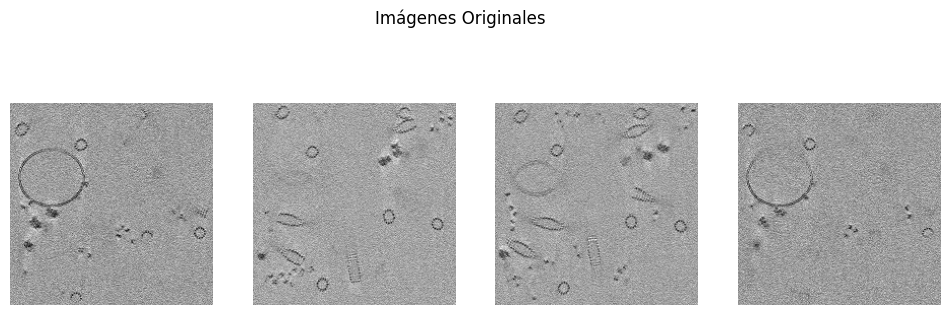

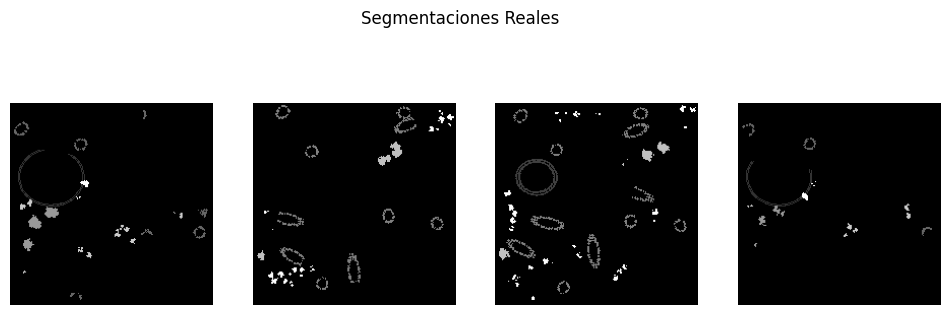

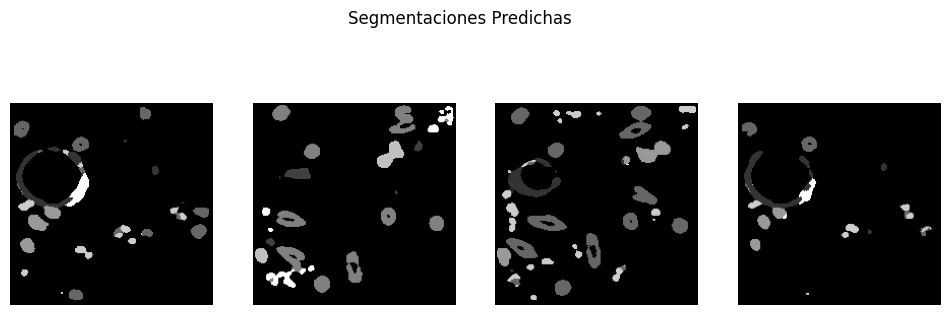

In [134]:
# Mostrar las imágenes originales
plt.figure(figsize=(12, 4))
plt.suptitle('Imágenes Originales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_segment[i], cmap='gray')
    plt.axis('off')

# Mostrar las segmentaciones reales
plt.figure(figsize=(12, 4))
plt.suptitle('Segmentaciones Reales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(segmented_images[i], cmap='gray')
    plt.axis('off')

# Mostrar las segmentaciones predichas
plt.figure(figsize=(12, 4))
plt.suptitle('Segmentaciones Predichas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(predicted_images[i], cmap='gray')
    plt.axis('off')

plt.show()

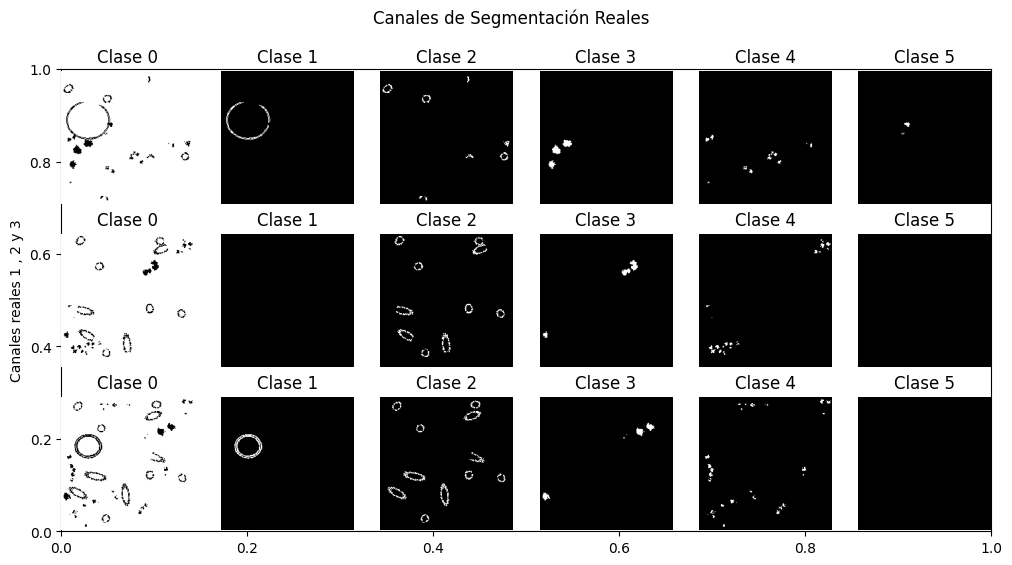

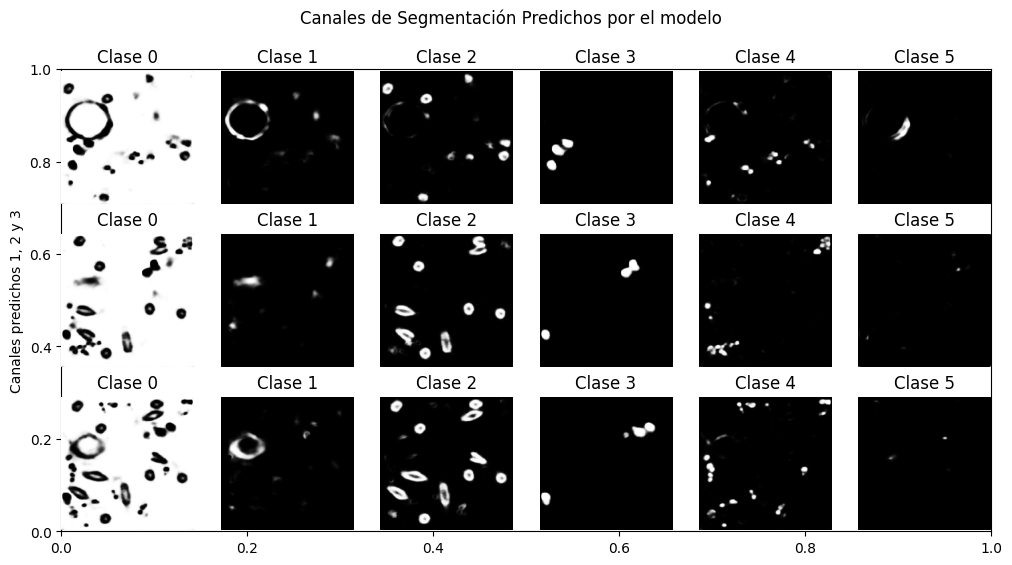

In [ ]:
def plot_segmentation_channels(tensors, title, fuente):
    num_images = len(tensors)  # Número de imágenes a mostrar
    num_classes = tensors.shape[-1]  # Número de clases (canales)
    
    plt.figure(figsize=(num_classes * 2, num_images * 2))
    plt.suptitle(title)
    plt.ylabel(fuente)
    

    for i in range(num_images):
        for j in range(num_classes):
            plt.subplot(num_images, num_classes, i * num_classes + j + 1)
            plt.imshow(tensors[i, :, :, j], cmap='gray')
            plt.axis('off')
            plt.title(f'Clase {j}')
    
    plt.show()

# Visualizar los canales de segmentación reales
plot_segmentation_channels(segmented_tensors[:3], 'Canales de Segmentación Reales', 'Canales reales 1 , 2 y 3')

# Visualizar los canales de la segmentación predicha
plot_segmentation_channels(predicted_tensor[:3], 'Canales de Segmentación Predichos por el modelo', 'Canales predichos 1, 2 y 3')

**E5:** Repite los ejercicios 2 e 3 pero esta vez generando un dataset mayor añadiendo los cortes en los planos X-Z, a lo largo del eje Y, e Y-Z, a lo largo del eje X. 

**Obtenemos el dataset al completo con todos los cortes posibles:**

In [191]:
def get_all_slices_tomograms(tomo, tomo_ground_truth):
    train_all_slices = []
    test_all_slices = []
    
    # Obtener las dimensiones del volumen
    dim_x, dim_y, dim_z = tomo.shape  

    # Corte en el plano X-Y (hasta el tamaño real de Z)
    for i in range(min(100, dim_z)):
        train_all_slices.append(tomo[:, :, i])
        test_all_slices.append(tomo_ground_truth[:, :, i])

    # Corte en los planos X-Z e Y-Z (hasta el tamaño real de X e Y)
    for i in range(min(400, dim_y)):
        train_all_slices.append(tomo[:, i, :])
        test_all_slices.append(tomo_ground_truth[:, i, :])

    for i in range(min(400, dim_x)):
        train_all_slices.append(tomo[i, :, :])
        test_all_slices.append(tomo_ground_truth[i, :, :])

    return train_all_slices, test_all_slices

# Llamada a la función
originals, ground_truth = get_all_slices_tomograms(tomo, tomo_ground_truth)


**Realización de las distintas tareas de preparación y preprocesamiento de los datos para facilitar el entrenamiento al modelo:**
- Realizamos un undersampling a las imágenes, en este caso las vamos a redimensionar a tamaño 128x128 ya que tenemos muchas más imágenes y necesitamos eficiencia computacional.
- Normalizamos las imágenes originales entre [-1, 1] y obtenemos los tensores one-hot de las imágenes ground truth
- Realizamos shuffle y partidicón del dataset en datos de entrenamiento y validación

In [192]:
originals_xy, gt_xy = resize_images(originals, ground_truth, target_size=(128, 128))
print("Imágenes redimensionadas mediante undersampling: ", originals_xy.shape, gt_xy.shape)
# División de datos en entrenamiento y validación (80-20) , shuffle y normalización de datos:
originals_normalized = normalize_images(originals_xy)

# Convertir las etiquetas a one-hot encoding
gt_one_hot = tf.keras.utils.to_categorical(gt_xy, num_classes=6)

o, gt = shuffle(originals_normalized, gt_one_hot, random_state=2025)
X_train, X_val, Y_train, Y_val = train_test_split(o, gt, test_size=0.2, random_state=2025)

Imágenes redimensionadas mediante undersampling:  (900, 128, 128) (900, 128, 128)


**Calculamos la ponderación de pesos correspondiente que habrá que asignarle a los píxeles de cada clase, ahora, al tener una muestra más grande, las ponderaciones son incluso más fiables ya que tenemos definida una gran distribución.**

In [193]:
# Contar la cantidad de píxeles por clase en el conjunto de entrenamiento
unique, counts = np.unique(gt_xy, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Distribución de clases en los datos de entrenamiento:", class_distribution)

# Distribución de clases (en píxeles)
class_pixel_count = {
    0: 14308993,  # Fondo
    1: 86652,    # Membranas
    2: 196202,    # Microtúbulos
    3: 74243,    # Complejo molecular grande
    4: 70183,    # Complejo molecular medio
    5: 9327      # Proteína de membrana
}

# Número total de píxeles en todo el dataset
total_pixels = sum(class_pixel_count.values())

# Cálculo de los pesos (inversamente proporcionales a la frecuencia de cada clase)
class_weights = {class_id: total_pixels / pixels for class_id, pixels in class_pixel_count.items()}

# Mostrar los pesos:
print("Pesos para cada clase:")
for class_id, weight in class_weights.items():
    print(f"Clase {class_id}: {weight:.4f}")

Distribución de clases en los datos de entrenamiento: {np.float32(0.0): np.int64(14308993), np.float32(1.0): np.int64(86652), np.float32(2.0): np.int64(196202), np.float32(3.0): np.int64(74243), np.float32(4.0): np.int64(70183), np.float32(5.0): np.int64(9327)}
Pesos para cada clase:
Clase 0: 1.0305
Clase 1: 170.1703
Clase 2: 75.1552
Clase 3: 198.6127
Clase 4: 210.1022
Clase 5: 1580.9585


In [194]:
# Pasamos cada uno de los tensores que representan los 6 canales a su imagen 2D:
Y_train_flat = np.argmax(Y_train, axis=-1)

# Inicializamos sample_weights a cero con la forma de Y_train
sample_weights = np.zeros(Y_train_flat.shape)  # (720, 128, 128)

# Recorremos cada clase y asignar su peso correspondiente a los píxeles que pertenezacan a ella
for class_id, weight in class_weights.items():
    # Asignar peso a cada píxel que pertenece a la clase `class_id`
    sample_weights[Y_train_flat == class_id] = weight
print('Forma sample_weights:' , sample_weights.shape)

Forma sample_weights: (720, 128, 128)


**Creación, Compilación y Entrenamiento del modelo final:**

In [195]:
# Creación arquitecura U-Net para segmentación de imagen
def u_net_segmentation_final(input_shape=(128, 128, 1), num_classes=6):
    inputs = layers.Input(shape=input_shape)

    # Down-sampling
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)

    # Up-sampling
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Concatenate()([u1, c2])  # Skip connection
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    u1 = layers.Conv2D(48, (3, 3), activation='relu', padding='same')(u1)
    

    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Concatenate()([u2, c1])  # Skip connection
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)
    u2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u2)

    # Salida
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(u2) 

    return keras.Model(inputs, outputs)

In [196]:
U_net_segmentation_final_model = u_net_segmentation_final()
U_net_segmentation_final_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 128, 128,  │        320 │ input_layer_10[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 128, 128,  │      9,248 │ conv2d_130[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 64, 64,    │          0 │ conv2d_131[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 64, 64,    │     13,872 │ max_pooling2d_20… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 64, 64,    │     20,784 │ conv2d_132[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 32, 32,    │          0 │ conv2d_133[0][0]  │
│ (MaxPooling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 32, 32,    │     27,712 │ max_pooling2d_21… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_134[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_135[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 32, 32,    │     36,928 │ conv2d_136[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_20    │ (None, 64, 64,    │          0 │ conv2d_137[0][0]  │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 64, 64,    │          0 │ up_sampling2d_20… │
│ (Concatenate)       │ 112)              │            │ conv2d_133[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 64, 64,    │     48,432 │ concatenate_20[0… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 64, 64,    │     20,784 │ conv2d_138[0][0]  │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_21    │ (None, 128, 128,  │          0 │ conv2d_139[0][0]  │
│ (UpSampling2D)      │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_21      │ (None, 128, 128,  │          0 │ up_sampling2d_21

 Total params: 284,454 (1.09 MB)

 Trainable params: 284,454 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [197]:
# Compilar el modelo
U_net_segmentation_final_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

# Entrenar el modelo
history = U_net_segmentation_final_model.fit(
    X_train, Y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_val, Y_val),
    sample_weight=sample_weights, # Pasamos la ponderación de clases para combatir el desbalance
    callbacks=[early_stopping])

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 26s 929ms/step - accuracy: 0.6639 - loss: 10.4323 - val_accuracy: 0.9016 - val_loss: 0.8638
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 875ms/step - accuracy: 0.8990 - loss: 9.0961 - val_accuracy: 0.8656 - val_loss: 0.5643
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8582 - loss: 8.5933 - val_accuracy: 0.8840 - val_loss: 0.4598
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8511 - loss: 7.7821 - val_accuracy: 0.6222 - val_loss: 1.0807
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8288 - loss: 7.1636 - val_accuracy: 0.8539 - val_loss: 0.5631
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.8545 - loss: 6.7357 - val_accuracy: 0.8319 - val_loss: 0.6519
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8383 - loss: 5.9721 - val_accuracy: 0.7598 - val_loss: 0.8094
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.8316 - loss: 5.5106 - val_accuracy: 0.8

### **Visualización de las segmentaciones realizadas por el modelo final mediante varios slices de prueba provenientes de diferentes tipos de cortes:**

In [198]:
indices = [3, 38, 15, 62]
images_to_segment = np.array([X_val[i] for i in indices])
segmented_tensors = np.array([Y_val[i] for i in indices])
segmented_images = [np.argmax(seg, axis=-1) for seg in segmented_tensors]

predicted_tensor = u_net_segmentation_task.predict(images_to_segment)
predicted_images = [np.argmax(pred, axis=-1) for pred in predicted_tensor]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


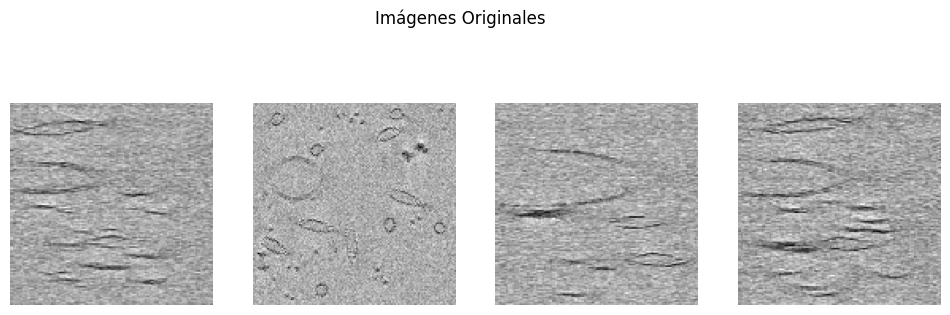

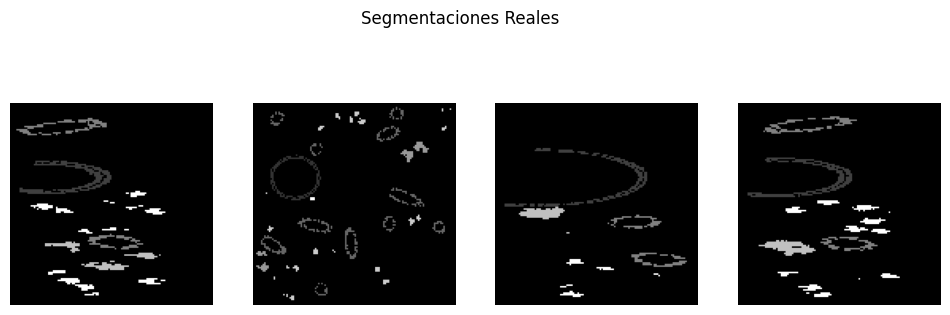

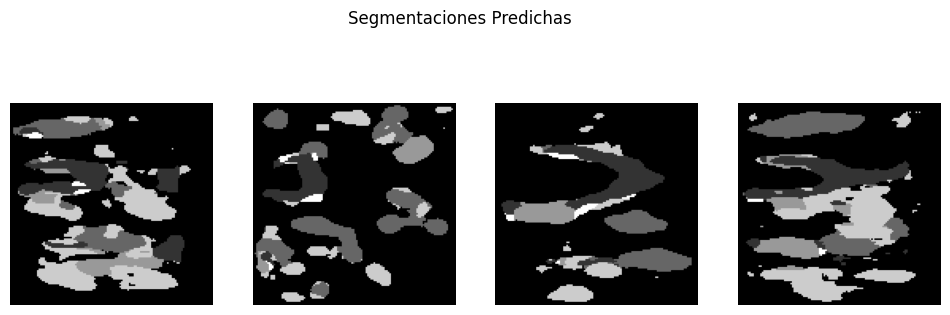

In [199]:
# Mostrar las imágenes originales
plt.figure(figsize=(12, 4))
plt.suptitle('Imágenes Originales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(images_to_segment[i], cmap='gray')
    plt.axis('off')

# Mostrar las segmentaciones reales
plt.figure(figsize=(12, 4))
plt.suptitle('Segmentaciones Reales')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(segmented_images[i], cmap='gray')
    plt.axis('off')

# Mostrar las segmentaciones predichas
plt.figure(figsize=(12, 4))
plt.suptitle('Segmentaciones Predichas')
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(predicted_images[i], cmap='gray')
    plt.axis('off')

plt.show()

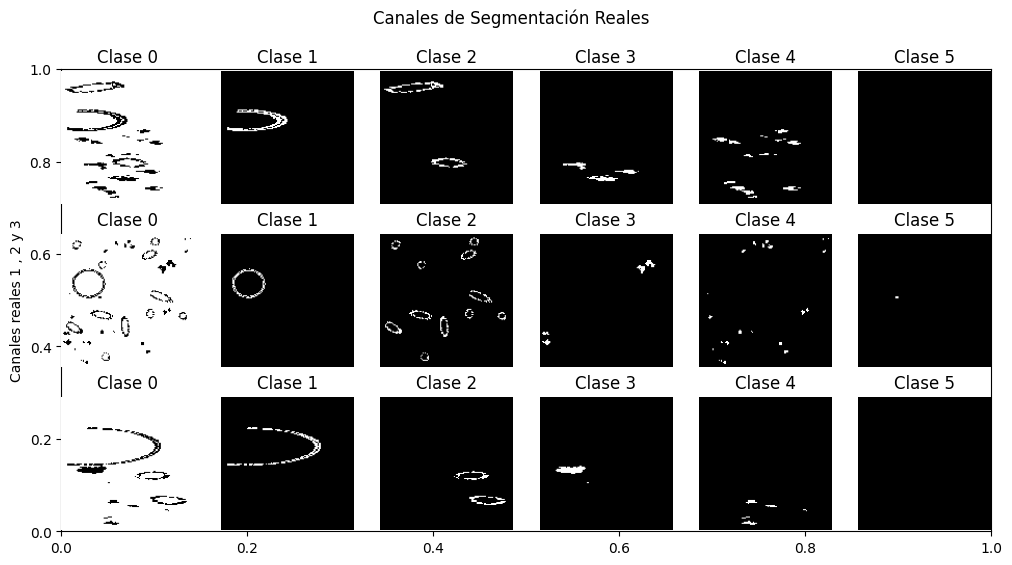

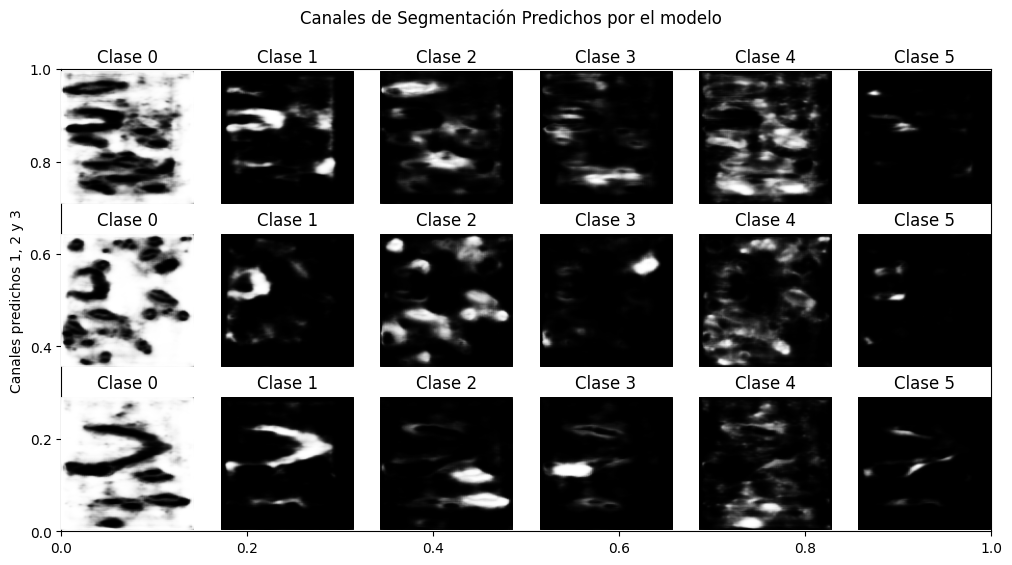

In [179]:
# Visualizar los canales de segmentación reales
plot_segmentation_channels(segmented_tensors[:3], 'Canales de Segmentación Reales', 'Canales reales 1 , 2 y 3')

# Visualizar los canales de la segmentación predicha
plot_segmentation_channels(predicted_tensor[:3], 'Canales de Segmentación Predichos por el modelo', 'Canales predichos 1, 2 y 3')